In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()  # upload kaggle.json file here

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d khanfashee/nih-chest-x-ray-14-224x224-resized

 99% 2.28G/2.30G [00:23<00:00, 162MB/s]
100% 2.30G/2.30G [00:23<00:00, 105MB/s]


In [ ]:
import zipfile
import os

# Unzip the dataset
zip_path = '/content/nih-chest-x-ray-14-224x224-resized.zip'  # Replace with the path to your downloaded zip file
unzip_path = '/content/dataset'  # The directory where you want to unzip the files
os.makedirs(unzip_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_path)






In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from PIL import Image
from tqdm.auto import tqdm
from typing import Dict
from pathlib import Path
import logging
import time
from prettytable import PrettyTable
from copy import deepcopy

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import densenet121
from torch.optim import Adam, lr_scheduler
import torchvision.transforms as tfms
import torchvision.transforms.functional as T

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
class CFG:
    CLASS_NAMES = [
        "Atelectasis",
        "Cardiomegaly",
        "Effusion",
        "Infiltration",
        "Mass",
        "Nodule",
        "Pneumonia",
        "Pneumothorax",
        "Consolidation",
        "Edema",
        "Emphysema",
        "Fibrosis",
        "Pleural_Thickening",
        "Hernia",
    ]
    BASE_PATH = Path("/content/dataset")
    BEST_MODEL_PATH = "models/best_model.pt"
    EPOCHS = 20
    DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    INTERVAL = 10

In [ ]:
CFG.DEVICE

device(type='cuda')

In [ ]:
df = pd.read_csv( CFG.BASE_PATH / "Data_Entry_2017.csv")

In [ ]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,058Y,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,058Y,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,058Y,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,081Y,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,081Y,F,PA,2582,2991,0.143,0.143,NaN


In [ ]:
# Make paths absolute
df["Image Index"] = [
    CFG.BASE_PATH / f"images-224/images-224/{path}" for path in df["Image Index"].values
]
# Remove "No Finding"
df = df[df["Finding Labels"].isin(["No Finding"]) == False]

In [ ]:
df.head(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,/content/dataset/images-224/images-224/0000000...,Cardiomegaly,0,1,058Y,M,PA,2682,2749,0.143,0.143,NaN
1,/content/dataset/images-224/images-224/0000000...,Cardiomegaly|Emphysema,1,1,058Y,M,PA,2894,2729,0.143,0.143,NaN
2,/content/dataset/images-224/images-224/0000000...,Cardiomegaly|Effusion,2,1,058Y,M,PA,2500,2048,0.168,0.168,NaN
4,/content/dataset/images-224/images-224/0000000...,Hernia,0,3,081Y,F,PA,2582,2991,0.143,0.143,NaN
5,/content/dataset/images-224/images-224/0000000...,Hernia,1,3,074Y,F,PA,2500,2048,0.168,0.168,NaN
6,/content/dataset/images-224/images-224/0000000...,Hernia,2,3,075Y,F,PA,2048,2500,0.168,0.168,NaN
7,/content/dataset/images-224/images-224/0000000...,Hernia|Infiltration,3,3,076Y,F,PA,2698,2991,0.143,0.143,NaN
8,/content/dataset/images-224/images-224/0000000...,Hernia,4,3,077Y,F,PA,2500,2048,0.168,0.168,NaN
9,/content/dataset/images-224/images-224/0000000...,Hernia,5,3,078Y,F,PA,2686,2991,0.143,0.143,NaN
10,/content/dataset/images-224/images-224/0000000...,Hernia,6,3,079Y,F,PA,2992,2991,0.143,0.143,NaN


In [ ]:
labels = np.zeros(shape=(len(df), 14))
for idx, lab in tqdm(enumerate(df["Finding Labels"].values), total=len(df)):
    lbls = lab.split("|")
    lbl_arr = np.zeros(len(CFG.CLASS_NAMES))
    for l in lbls:
        lbl_arr[CFG.CLASS_NAMES.index(l)] = 1
    labels[idx] = lbl_arr


  0%|          | 0/51708 [00:00<?, ?it/s]

In [ ]:
labels

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
d = {k:v for k, v in zip(CFG.CLASS_NAMES, labels.transpose())}

In [ ]:
for k, v in d.items():
    df[k] = v

In [ ]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia
0,/content/dataset/images-224/images-224/0000000...,Cardiomegaly,0,1,058Y,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,/content/dataset/images-224/images-224/0000000...,Cardiomegaly|Emphysema,1,1,058Y,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,/content/dataset/images-224/images-224/0000000...,Cardiomegaly|Effusion,2,1,058Y,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,/content/dataset/images-224/images-224/0000000...,Hernia,0,3,081Y,F,PA,2582,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,/content/dataset/images-224/images-224/0000000...,Hernia,1,3,074Y,F,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
df.to_csv("final.csv", index=False)

Plotting Images.

In [ ]:
def plot_images(df, rows, columns, figsize=(20, 20)):
    """
    Function to plot images
    """
    fig, axs = plt.subplots(rows, columns, figsize=figsize)
    idx = 0
    for i in range(rows):
        for j in range(columns):
            image = np.asarray(Image.open(df["Image Index"].values[idx]).convert("RGB"))
            labels = df["Finding Labels"].values[idx].split("|")
            axs[i, j].imshow(image)
            axs[i, j].yaxis.set_visible(False)
            axs[i, j].set_xticklabels([])
            axs[i, j].set_xlabel(labels)
            idx += 1
    plt.show()

In [ ]:
# Read the saved data
df = pd.read_csv("./final.csv")

In [ ]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia
0,/content/dataset/images-224/images-224/0000000...,Cardiomegaly,0,1,058Y,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,/content/dataset/images-224/images-224/0000000...,Cardiomegaly|Emphysema,1,1,058Y,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,/content/dataset/images-224/images-224/0000000...,Cardiomegaly|Effusion,2,1,058Y,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,/content/dataset/images-224/images-224/0000000...,Hernia,0,3,081Y,F,PA,2582,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,/content/dataset/images-224/images-224/0000000...,Hernia,1,3,074Y,F,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


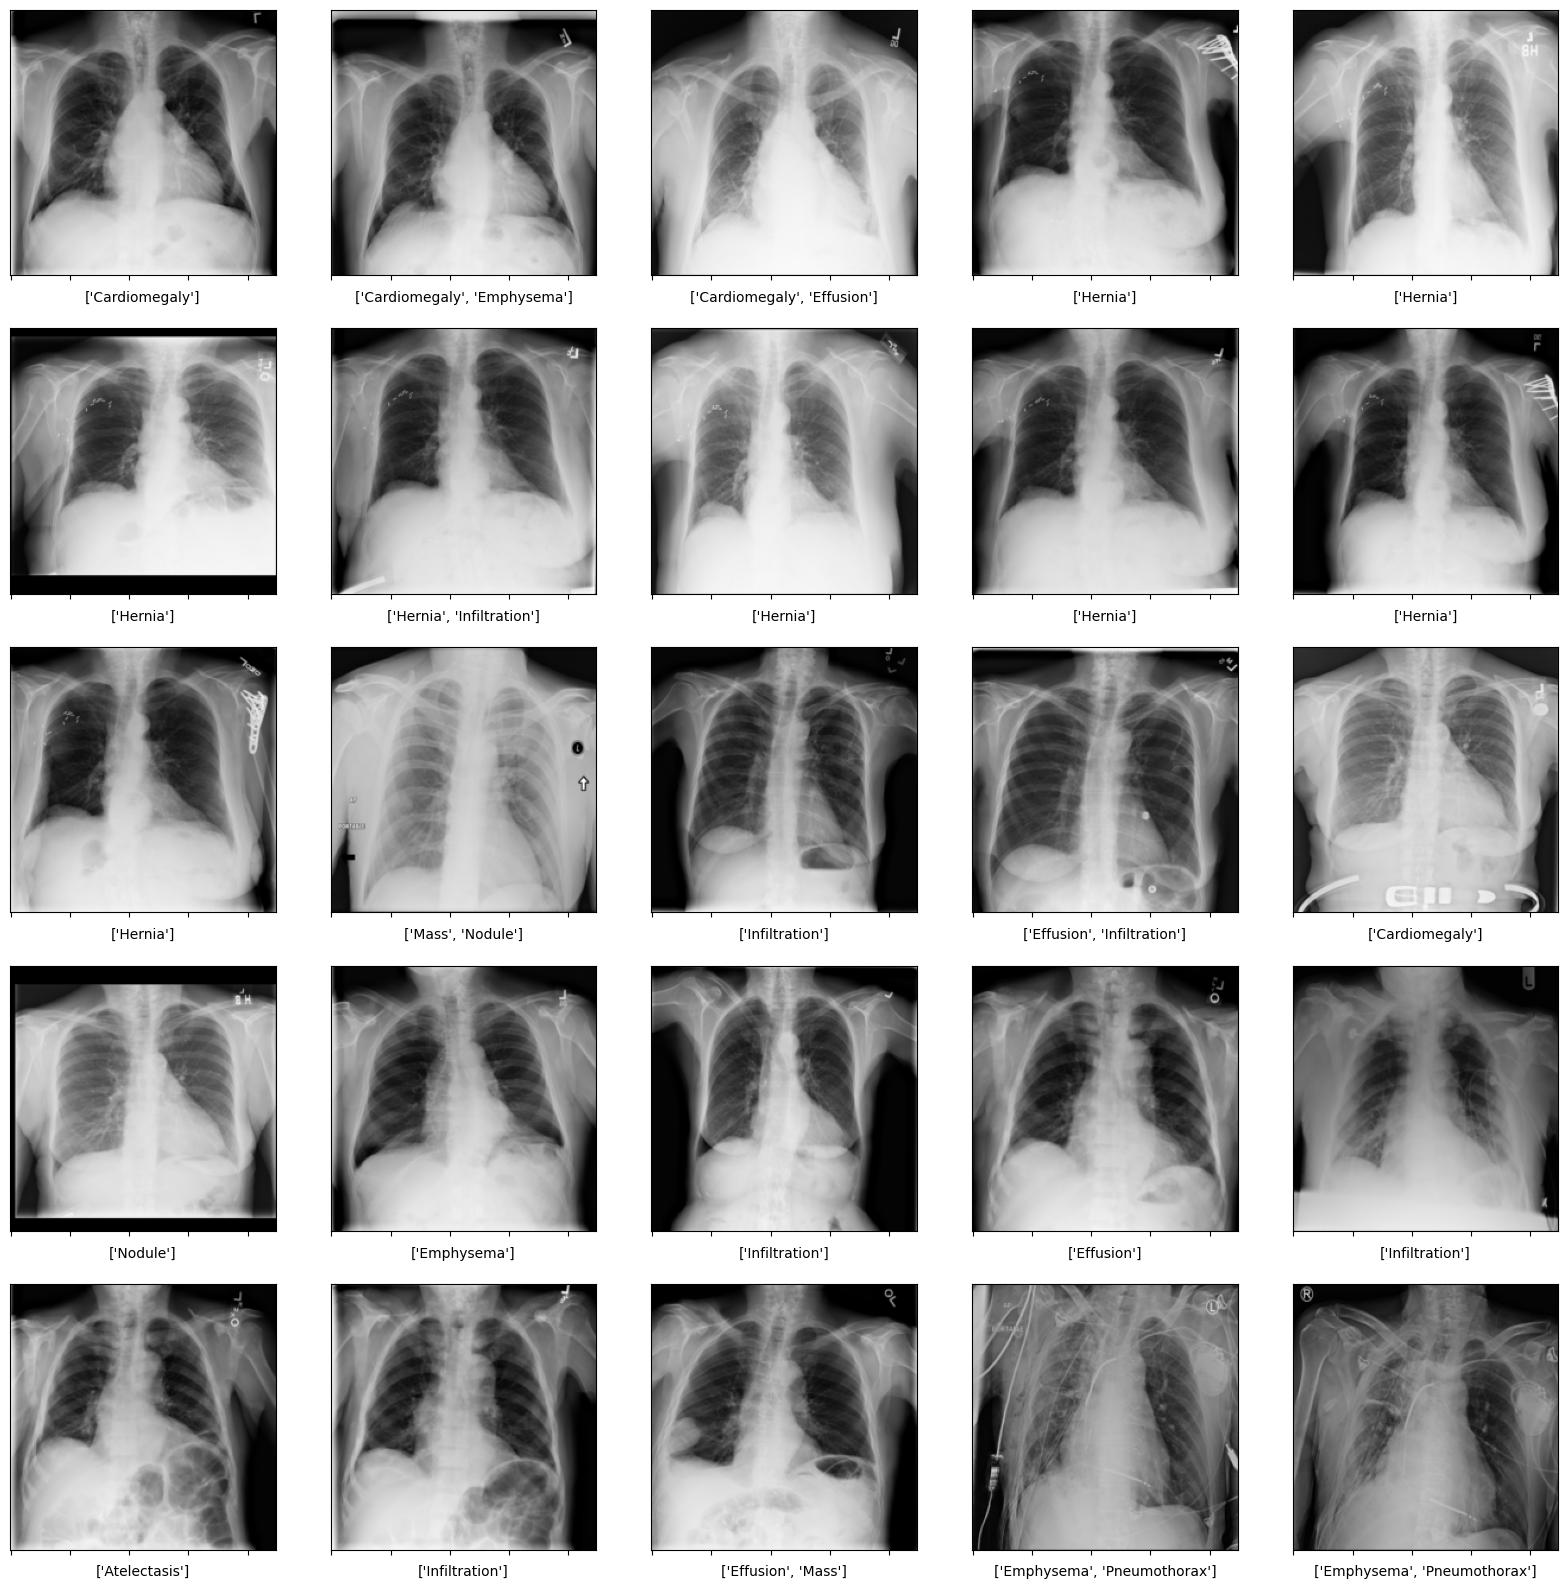

In [ ]:
plot_images(df, 5, 5)

PyTorch Dataset

In [ ]:
class CheXNetData(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __getitem__(self, idx):
        image = Image.open(self.df["Image Index"].values[idx]).convert("RGB")
        label = self.df.iloc[:, 2:].values[idx]

        if self.transform:
            image = self.transform(image=np.asarray(image))["image"]

        label = torch.tensor(label, dtype=torch.float)

        return image, label

    def __len__(self):
        return len(df)

In [ ]:
transforms = A.Compose(transforms=[A.Normalize(), ToTensorV2()])

In [ ]:
ds = CheXNetData(df=df, transform=transforms)

In [ ]:
image, label = ds[0]

TypeError: ignored

In [ ]:
image.size(), label.size()

Split the dataset

In [ ]:
#Split into Train and Test
total = len(ds)
train_len = int(0.8 * total)
val_len = total - train_len

train_ds, test_ds = random_split(dataset=ds, lengths=[train_len, val_len])

In [ ]:
#Split into Train and Validation
total = len(train_ds)
train_len = int(0.8 * total)
val_len = total - train_len

train_ds, val_ds = random_split(dataset=train_ds, lengths=[train_len, val_len])

In [ ]:
print(f"The lengths of train, val and test dataset: {len(train_ds)} images, {len(val_ds)} images, and {len(test_ds)} images")

In [ ]:
ds_size = {
    "train": len(train_ds), "val": len(val_ds), "test": len(test_ds)
} # Size dictionary

In [ ]:
ds_size

Create the DataLoader(s)

In [ ]:
loaders = {
    "train": DataLoader(train_ds, batch_size=64, shuffle=True),
    "val": DataLoader(val_ds, batch_size=32),
    "test": DataLoader(test_ds, batch_size=32)
}

In [ ]:
loaders

PyTorch Model

In [ ]:
class DenseNet121(nn.Module):
    def __init__(self, n_classes):
        super(DenseNet121, self).__init__()

        self.densenet121 = densenet121(pretrained=True)
        n_features = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(n_features, n_classes), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.densenet121(x)
        return x

Training

In [ ]:
ds_batches = {k : len(v) for k, v in loaders.items()}
ds_batches

In [ ]:
# check is models folder exists
Path("models").mkdir(exist_ok=True)

# Set up logger
logging.basicConfig(
    filename="train.log",
    format="%(asctime)s - %(levelname)s - %(message)s",
    level=logging.INFO,
    filemode="w",
)

Utilities

In [ ]:
def calc_mean_auc(labels: torch.tensor, preds: torch.tensor):
    labels = labels.cpu().detach().numpy()
    preds = preds.cpu().detach().numpy()

    per_class_AUROC = []
    for i, name in enumerate(CFG.CLASS_NAMES):
        try:
             per_class_AUROC.append(roc_auc_score(labels[:, i], preds[:, i]))
        except ValueError:
            pass
    mean_roc_auc = np.array(per_class_AUROC).mean()

    return mean_roc_auc

Run one epoch

In [ ]:
best_AUROC = 0.0 # Global AUROC

def run_one_epoch(
    epoch: int,
    ds_sizes: Dict[str, int],
    dataloaders: Dict[str, DataLoader],
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    loss: nn.Module,
    scheduler: torch.optim.lr_scheduler
):
    """
    Run one complete train-val loop

    Parameter
    ---------

    ds_sizes: Dictionary containing dataset sizes
    dataloaders: Dictionary containing dataloaders
    model: The model
    optimizer: The optimizer
    loss: The loss

    Returns
    -------

    metrics: Dictionary containing metrics

    """
    global best_AUROC

    metrics = {}
    AUROCs = []

    for phase in ["train", "val"]:
        logging.info(f"{phase.upper()} phase")

        if phase == "train":
            model.train()
        else:
            model.eval()

        avg_loss = 0
        running_corrects = 0

        for batch_idx, (images, labels) in enumerate(
            tqdm(dataloaders[phase], total=len(dataloaders[phase]))
        ):

            images = images.to(CFG.DEVICE)
            labels = labels.to(CFG.DEVICE)

            # Zero the gradients
            optimizer.zero_grad()

            # Track history if in phase == "train"
            with torch.set_grad_enabled(phase == "train"):
                outputs = model(images)
                loss = criterion(outputs, labels)

                if phase == "train":
                    loss.backward()
                    optimizer.step()

                # Calculate AUROC
                auroc = calc_mean_auc(labels, outputs)
                AUROCs.append(auroc)

            avg_loss += loss.item() * images.size(0)

            if batch_idx % CFG.INTERVAL == 0:
                logging.info(
                    f"Epoch {epoch} - {phase.upper()} - Batch {batch_idx} - Loss = {round(loss.item(), 3)} | AUROC = {round(auroc, 3)}"
                )

        epoch_loss = avg_loss / ds_sizes[phase]
        epoch_val_mean = np.array(AUROCs).mean()

        # step the scheduler
        if phase == "train":
            scheduler.step(epoch_loss)

        # save best model wts
        if phase == "val" and epoch_val_mean > best_AUROC:
            best_AUROC = epoch_val_mean
            best_model_wts = deepcopy(model.state_dict())
            timestampTime = time.strftime("%H%M%S")
            timestampDate = time.strftime("%d%m%Y")
            timestampEND = timestampDate + '-' + timestampTime
            best_model_path = f"models/CheXNet-{timestampEND}.pt"
            torch.save({
                "epoch" : epoch, "val_loss": epoch_loss, "val_AUROC": epoch_val_mean, "model": best_model_wts
            }, best_model_path)

        # Metrics tracking
        if phase == "train":
            metrics["train_loss"] = round(epoch_loss, 3)
        else:
            metrics["val_loss"] = round(epoch_loss, 3)
            metrics["val_mean_AUROC"] = round(epoch_val_mean, 3)

    return metrics

In [ ]:
def train(dataloaders, ds_sizes, model, optimizer, criterion, scheduler):
    table = PrettyTable(
        field_names=["Epoch", "Train Loss", "Val Loss", "Val Mean AUROC"]
    )

    for epoch in range(CFG.EPOCHS):

        start = time.time()

        metrics = run_one_epoch(
            epoch=epoch,
            ds_sizes=ds_sizes,
            dataloaders=dataloaders,
            model=model,
            optimizer=optimizer,
            loss=criterion,
            scheduler=scheduler
        )

        end = time.time() - start

        print(f"Epoch completed in: {round(end/60, 3)} mins")

        table.add_row(
            row=[
                epoch + 1,
                metrics["train_loss"],
                metrics["val_loss"],
                metrics["val_mean_AUROC"]
            ]
        )
        print(table)

    # Write results to file
    with open("results.txt", "w") as f:
        results = table.get_string()
        f.write(results)

Set-up Model, Optimizer & Loss

In [ ]:
model = DenseNet121(n_classes=14).to(CFG.DEVICE)
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, mode='min', patience=1)

In [ ]:
train(
    dataloaders=loaders,
    ds_sizes=ds_size,
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler
)

In [ ]:
with torch.no_grad():
    model.eval()
    out_gt = torch.FloatTensor()
    out_pred = torch.FloatTensor()
    for images, labels in tqdm(loaders["test"]):
        images = images.to(CFG.DEVICE)
        labels = labels.to(CFG.DEVICE)

        outputs = model(images)
        outputs = outputs.cpu().detach()

        out_gt = torch.cat((out_gt, labels.cpu().detach()), 0)
        out_pred = torch.cat((out_pred, outputs.data), 0)

In [ ]:
torch.save(model, 'model_complete.pth')

In [ ]:
labels = out_gt.numpy()
preds = out_pred.numpy()

per_class_AUROC = []

print("-----PER - CLASS AUROC------")

for i, name in enumerate(CFG.CLASS_NAMES):
    try:
         print(f"{name} - {round(roc_auc_score(labels[:, i], preds[:, i]), 3)}")
    except ValueError:
        pass
# mean_roc_auc = np.array(per_class_AUROC).mean()
